In [5]:
import pandas as pd
import seaborn as sns
from scipy import stats
import plotnine as gg
import matplotlib.pyplot as plt
from poola import core as pool
import seaborn as sns
import gpplot as gpp 


In [6]:
def count_elements(seq):
    seqs = {}
    for i in seq:
        seqs[i] = seqs.get(i, 0) + 1
        
    return seqs

In [7]:
dolcetto = pd.read_excel('../data/sanson_2018/Dolcetto_CRISPRi_readcount_mod.xlsx')

In [8]:
dolcetto.sgRNA_Sequence.value_counts()

AAAAAAAAAATACTGAGAGA    1
GCTTGCTTTCCTGGCGCTGG    1
GCTTGCCAGCCGAGGCAGCA    1
GCTTGCCTTGCTCGGCTCTG    1
GCTTGCGCAGTAGCTGAACG    1
                       ..
CCTCGCGGGACCCACAGAGG    1
CCTCGCGTAGCACCTCGTCG    1
CCTCGCTATGGTAAGAAGTG    1
CCTCGCTCAGCACCAGCCGA    1
TTTTTCTCACCCGATGAATC    1
Name: sgRNA_Sequence, Length: 57050, dtype: int64

In [9]:
essential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/essential-genes-Hart2015.txt',
                            names=['GENE'])
nonessential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/non-essential-genes-Hart2014.txt',
                                   names=['GENE'])
all_designs = pd.read_table('../../../gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRi_RS3seq-Chen2013_Ensembl_20220808.txt.gz')

# Rep correlation 

In [10]:
lognorms = pool.lognorm_columns(reads_df=dolcetto, columns=['pDNA',
 'HT29_RepA',
 'HT29_RepB',
 'HT29_RepC',
 'A375_RepA',
 'A375_RepB',
 'A375_RepC',
 'pDNA_A375'])

In [11]:
filtered_lognorms = pool.filter_pdna(lognorm_df=lognorms, pdna_cols=['pDNA', 'pDNA_A375'], z_low=-3)
print('pDNA Filtered: ' + str(lognorms.shape[0] - filtered_lognorms.shape[0]))

pDNA Filtered: 436


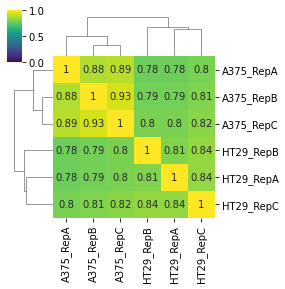

In [12]:
cors = lognorms[[
 'HT29_RepA',
 'HT29_RepB',
 'HT29_RepC',
 'A375_RepA',
 'A375_RepB',
 'A375_RepC']].corr()
sns.clustermap(cors, vmin= 0, cmap= 'viridis', annot= True, figsize= (4,4))
gpp.savefig('../figure/sanson_rep_corr.pdf', dpi=300)

In [13]:
long_cors = (cors.reset_index()
             .rename({'index': 'condition_rep1'}, axis=1)
             .melt(id_vars='condition_rep1',
                   var_name='condition_rep2', value_name='r'))


In [14]:
long_cors[['condition1', 'rep1']] = long_cors['condition_rep1'].str.split('_', expand=True)[[0, 1]]
long_cors[['condition2', 'rep2']] = long_cors['condition_rep2'].str.split('_', expand=True)[[0, 1]]


In [15]:
filtered_cors = long_cors[(long_cors['condition1'] == long_cors['condition2']) &
                          (long_cors['rep1'] != long_cors['rep2'])]


In [16]:
filtered_cors

,condition_rep1,condition_rep2,r,condition1,rep1,condition2,rep2
1,HT29_RepB,HT29_RepA,0.812260,HT29,RepB,HT29,RepA
2,HT29_RepC,HT29_RepA,0.836120,HT29,RepC,HT29,RepA
6,HT29_RepA,HT29_RepB,0.812260,HT29,RepA,HT29,RepB
8,HT29_RepC,HT29_RepB,0.836140,HT29,RepC,HT29,RepB
12,HT29_RepA,HT29_RepC,0.836120,HT29,RepA,HT29,RepC
13,HT29_RepB,HT29_RepC,0.836140,HT29,RepB,HT29,RepC
22,A375_RepB,A375_RepA,0.881952,A375,RepB,A375,RepA
23,A375_RepC,A375_RepA,0.891313,A375,RepC,A375,RepA
27,A375_RepA,A375_RepB,0.881952,A375,RepA,A375,RepB
29,A375_RepC,A375_RepB,0.934657,A375,RepC,A375,RepB


In [17]:
mean_pearson = filtered_cors['r'].mean()
print('Mean correlation: ' + str(round(mean_pearson, 4)))

Mean correlation: 0.8654


# ROC-AUC

In [18]:
lfc_df = pool.calculate_lfcs(lognorm_df=filtered_lognorms[['sgRNA_Sequence','pDNA',
 'HT29_RepA',
 'HT29_RepB',
 'HT29_RepC',
 'A375_RepA',
 'A375_RepB',
 'A375_RepC']], ref_col='pDNA', target_cols=['HT29_RepA',
 'HT29_RepB',
 'HT29_RepC',
 'A375_RepA',
 'A375_RepB',
 'A375_RepC'])

In [19]:
sg_list = list(lfc_df['sgRNA_Sequence'].unique())


In [20]:
avg_replicate_lfc_df = pool.average_replicate_lfcs(lfcs=lfc_df, guide_col='sgRNA_Sequence', condition_indices=[0],
                                                   sep='_')

In [24]:
design_cols = ['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', "sgRNA 'Cut' Site TSS Offset", 'On-Target Efficacy Score','DHS Score','Off-Target Rank','Pick Order']


In [25]:
lfcs_designs = (avg_replicate_lfc_df.rename({'sgRNA_Sequence': 'sgRNA Sequence'}, axis=1)
                .merge(all_designs[design_cols + ['# Off-Target Tier I Match Bin I Matches']], how = 'inner', on = 'sgRNA Sequence'))
roc_aucs, _ = pool.get_roc_aucs(lfcs=lfcs_designs, tp_genes=essential_genes.GENE,
                                fp_genes=nonessential_genes.GENE, gene_col='Target Gene Symbol',
                                score_col='avg_lfc', condition_col='condition')
roc_aucs

,condition,ROC-AUC
0,A375,0.910681
1,HT29,0.898394


In [26]:
roc_aucs['ROC-AUC'].mean()

0.904537541477755

# Compare different normalization techniques

In [28]:
relevant_sgs_designs = lfcs_designs[lfcs_designs['Target Gene Symbol'].isin(essential_genes.GENE)]
filtered_sgs = relevant_sgs_designs[relevant_sgs_designs['# Off-Target Tier I Match Bin I Matches'] == '0'].copy()

In [31]:
filtered_sgs['Target Gene Symbol'].value_counts()

SRCAP       12
MED14       12
SEC16A      12
RPP38       12
U2AF1       12
            ..
INTS7        2
RPAIN        2
PTPMT1       2
SLC7A6OS     2
DHX16        2
Name: Target Gene Symbol, Length: 1461, dtype: int64

In [19]:

filtered_sgs['gene_mean_centered'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                      .avg_lfc
                                      .transform(lambda x: -(x - x.mean())))
filtered_sgs['gene_rank'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                      .avg_lfc
                             .rank(pct=True, ascending=False))

filtered_sgs['gene_zscore'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                      .avg_lfc
                               .transform(lambda x: -(x - x.mean())/x.std()))
filtered_sgs['gene_median_centered'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                      .avg_lfc
                                        .transform(lambda x: -(x - x.median())))
filtered_sgs['gene_robust_zscore'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                      .avg_lfc
                                      .transform(lambda x: -(x - x.median())/(x.quantile(0.75) - x.quantile(0.25))))

sg_avg_rank = (filtered_sgs.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', 
                                      'On-Target Efficacy Score','sgRNA \'Cut\' Site TSS Offset',
                                     'DHS Score','Off-Target Rank','Pick Order'])
               .agg(avg_rank = ('gene_rank', 'mean'),
                    avg_mean_centered_neg_lfc = ('gene_mean_centered', 'mean'),
                    avg_zscore_neg_lfc = ('gene_zscore', 'mean'),
                    avg_median_centered_neg_lfc = ('gene_median_centered', 'mean'),
                    avg_robust_zscore_neg_lfc = ('gene_robust_zscore', 'mean'),
                    avg_lfc = ('avg_lfc', 'mean'))
               .reset_index())

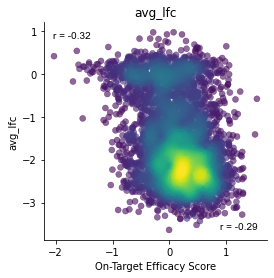

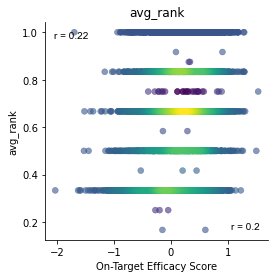

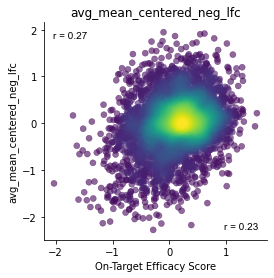

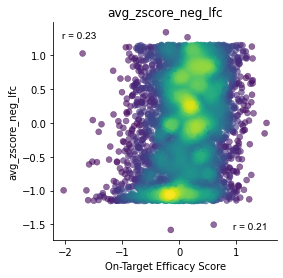

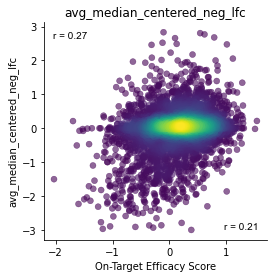

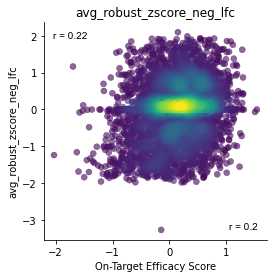

In [20]:
for score in ['avg_lfc','avg_rank', 'avg_mean_centered_neg_lfc', 'avg_zscore_neg_lfc',
              'avg_median_centered_neg_lfc', 'avg_robust_zscore_neg_lfc']:
    plt.subplots(figsize=(4,4))
    gpp.point_densityplot(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                             y=score, x='On-Target Efficacy Score')
    gpp.add_correlation(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                           y=score, x='On-Target Efficacy Score')
    gpp.add_correlation(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                           y=score, x='On-Target Efficacy Score', method='spearman', loc='lower right')
    plt.title(score)
    sns.despine()

In [21]:
lfcs_designs.to_csv('../data/sanson_2018/sanson2018_condition_lfcs.csv', index=False)
sg_avg_rank.to_csv('../data/sanson_2018/sanson2018_activity.csv', index=False)